Last time, we proved that there was an increase in the Sterling Diversity Index for papers published by a group after an IGERT was awarded.  But that is basic statistics, not data science.  It turns out that along with the 3139 papers that were published by the five IGERT groups in my sample, I have 307 papers which aren't affiliated with any group.  I'm not sure how that happened, but it provides a useful finale to the project.  Can I fairly assign each of the 307 error papers to one of my five IGERT groups?

Each of the five IGERTs works on its own research topic, so to do this, we need to find a data science method to figure out what the topics of the five groups are, and assign new cases to each group with some degree of certainty. This sounds a lot like good case for logistic regression to me.  To do this, I've expanded the data with the citation categories for each paper, which I used to calculate the Stirling Diversity Index. It that looks like this, extended out through the 224 Web of Science subject categories.

|Unknown|	BIOLOGY|	MATHEMATICAL & COMPUTATIONAL BIOLOGY|	STATISTICS & PROBABILITY|	ENGINEERING, ELECTRICAL & ELECTRONIC|	COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE|	ROBOTICS|	TELECOMMUNICATIONS|...|
|---|---|---|---|---|---|---|---|---
|9|1|1||		12||||			1|

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('5-scientometrics101-cites.csv')
data.head()

,alias,first_author,group,group_start,number_authors,sdi,times_cited,journal,pub_year,velocity,...,HISTORY OF SOCIAL SCIENCES,LITERATURE,LOGIC,LANGUAGE & LINGUISTICS,LITERARY THEORY & CRITICISM,LITERARY REVIEWS,FOLKLORE,CLASSICS,MUSIC,MEDIEVAL & RENAISSANCE STUDIES
0,T3015,False,E,2011,5,0.453791,9,MACROMOLECULES,2014,2.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T1954,True,E,2011,6,0.578180,7,BIOMACROMOLECULES,2014,1.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T1144,False,D,2010,4,0.288167,15,TEACH. SOCIOL.,2012,2.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T2953,False,C,2009,6,0.204894,925,ADV. FUNCT. MATER.,2007,84.090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T1635,True,A,2011,2,0.376589,4,J. APPL. RES. INTELLECT. DISABIL.,2017,4.000000,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


We import LogisticRegression and some the usual data wrangling packages, then set up our X to be all the citation categories of papers not in the ERROR group, and y to be the group that they are actually in.

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

data2=data[data.group != 'ERROR']

X = data2.iloc[:,11:]
X.fillna(0, inplace=True)
y = data2.loc[:,'group']

X_train, X_test, y_train, y_test =train_test_split(
    X, y, test_size=0.3, random_state=10, stratify=y)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std =sc.transform(X_test)

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Our accuracy is 0.72, which is acceptably above chance, 0.2 in this case. I tried changing the hyperparameters, and a support vector machine, and couldn't get higher accuracy.

In [170]:
lr.score(X_test_std, y_test)

0.7261146496815286

Let's inspect the confusion matrix, to see where we're guessing wrong.  It's clear that in terms of raw numbers, papers from Group C dominate, and we have trouble distinguishing papers in Group B and Group E from those in group C. This makes sense, since all I know from my prior investifation those three groups work in nanotechnology, among other things.  It is plausible that there is research on something fundamental, like the properties of carbon nanotubes, which all three groups contribute to.

[[ 55   7  16   8   3]
 [  7  99  58   1  12]
 [  4  16 359   4  21]
 [  6   4  20  92   6]
 [  3   8  54   0  79]]


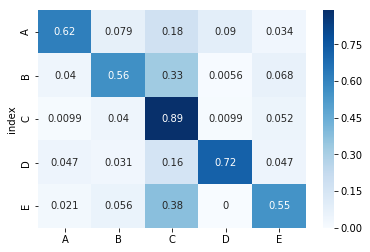

In [171]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, lr.predict(X_test_std))
print (conf_mat)

from sklearn.preprocessing import normalize

normed_conf = normalize(conf_mat, axis=1, norm='l1')
normed_conf = pd.DataFrame(normed_conf)
normed_conf.columns = ['A','B','C','D', 'E']
normed_conf['index']=['A','B','C','D', 'E']
normed_conf.set_index(['index'], inplace=True)
normed_conf

fig = sns.heatmap(normed_conf, cmap='Blues', annot=True)

And finally, we grab the ERROR papers and run them through the linear regression to see that most of them belong to group C.

In [172]:
data3=data[data.group == 'ERROR']
X3 = data3.iloc[:,11:]
X3.fillna(0, inplace=True)
X3_std = sc.transform(X3)
guesses = list(lr.predict(X3))

for group in ['A','B','C','D', 'E']:
    print(group, guesses.count(group))

A 8
B 0
C 280
D 13
E 6
